# Notebook Setup

In [ ]:
!mkdir /datasets -p
from google.colab import drive
drive.mount('/datasets/drive', force_remount=True)

First, some environment variables must be set and we must also import some useful libraries.

First of all, we need a simple flag to detect wether or not this is the first time running this notebook. Having it at `0` means that this is _not_ the first execution, so we don't need to re-generate all the data-augmented images and re-sample the negative images (see the subsequent sections); having it at `1` means that this _is_ the first run.

In [ ]:
%env FIRST_RUN=0

We can set the directory containing all the data, subdivided in three folders (`positive`, `negative`, and `modified`). You may need to change this path acording to the directory structure of your drive.

In [ ]:
%env DATA_DIR=/datasets/drive/MyDrive/Computer Vision/data

We can also set the random seed that will be used throughout this whole notebook.

In [ ]:
import os
import random
%env RANDOM_SEED=1234
random.seed(os.getenv('RANDOM_SEED'))

To load the actual images and do various operations, we'll need some more libraries.

In [ ]:
!pip install nibabel p_tqdm 2>&1 >/dev/null

from p_tqdm import p_uimap
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import glob
import pandas as pd
import sys
import re
import cv2

# Exploring the Dataset
From the [OASIS-3 website](https://oasis-brains.org) we are able to download all the data, regarding the various available scans, sessions, and subjects, in CSV format. Once downloaded, we can import the downloaded data using [Pandas](https://pandas.pydata.org) to explore them and get some basic statistical information.

In [ ]:
subjects = pd.read_csv(os.path.join(os.getenv('DATA_DIR'), 'csv/subjects.csv'))
clinical_data = pd.read_csv(os.path.join(os.getenv('DATA_DIR'), 'csv/clinical-data.csv'))
mri_data = pd.read_csv(os.path.join(os.getenv('DATA_DIR'), 'csv/mr.csv'))
pet_data = pd.read_csv(os.path.join(os.getenv('DATA_DIR'), 'csv/pet.csv'))
pup_data = pd.read_csv(os.path.join(os.getenv('DATA_DIR'), 'csv/pup.csv'))

# By default, the CSVs do not contain some information explicitly
# (although the columns have been defined). Thus, here we set them
# to usable values.

pup_data['Date'] = (pup_data['PUP_PUPTIMECOURSEDATA ID']
                        .apply(lambda s: int(s.split('_')[3][1:])))
pup_data['Subject'] = (pup_data['PUP_PUPTIMECOURSEDATA ID']
                           .apply(lambda s: s.split('_')[0]))

clinical_data['Date'] = (clinical_data['ADRC_ADRCCLINICALDATA ID']
                             .apply(lambda s: int(s.split('_')[2][1:])))

pet_data['Tracer'] = (pet_data['XNAT_PETSESSIONDATA ID']
                          .map(lambda x: x.split('_')[1]))

Once the data are loaded, we can check how many subjects were involved in the data collection, as well as check how many MRI and PET scans are available and how many PET scans were processed with the [PET Unified Pipeline (PUP)](https://github.com/ysu001/PUP).

In [ ]:
print("Number of subjects:", subjects.shape[0])
print("Number of MRI scans:", mri_data.shape[0])
print("Number of PET scans:", pet_data.shape[0])
print("Number of PUP results:", pup_data.shape[0])

To better understand which of the available PET we're going to use for the training of the diagnostic model, we're going to further detail the composition of the PUP scans' dataset by exploring how many scans are available for each type of PET. 

In [ ]:
pet_data['Tracer'].value_counts()

We can further repeat the same operation as before, but showing the results as percentages and collapsing the two amyloid PETs.

In [ ]:
(pet_data['Tracer']
    .replace('PIB|AV45', 'Amyloid', regex=True)
    .value_counts(normalize=True))

Since the amyloid-PET scans comprise almost 93% of the entire dataset, we can focus on using them to train the model. This choice allows the use of the processed PET scans yielded by the PUP, since no FDG-PET examples are available.

In [ ]:
pup_data['tracer'].value_counts()

Although the number of available PET scans is slightly less, this choice assures that the used images are high-quality images from a medical point of view.

## The PET scans

We can load an example PET scan, for both AV45-PET and PIB-PET, in order to get various information on the available image formats and sizes.

### AV45-PET

We can now load an example AV45-PET. The normalized motion-corrected image is in `.hdr` format and we can print its dimensions.

In [ ]:
av45_example = nib.load(os.path.join(os.getenv('DATA_DIR'), 'positive', 'OAS30024_AV45_d0084n_moco.4dfp.hdr'))
av45_example.shape

Since it has four different dimensions, we're going to plot the average value in time for each voxel.

In [ ]:
plt.imshow(np.rot90(np.mean(av45_example.dataobj, axis=3)[170,:,:]))

### PIB-PET

We can now load an example PIB-PET. The normalized motion-corrected image is in `.hdr` format and we can print its dimensions.

In [ ]:
pib_example = nib.load(os.path.join(os.getenv('DATA_DIR'), 'positive', 'OAS30027_PIB_d2394n_moco.4dfp.hdr'))
pib_example.shape

Since it has four different dimensions, we're going to plot the average value in time for each voxel.

In [ ]:
plt.imshow(np.rot90(np.mean(pib_example.dataobj, axis=3)[50,:,:]))

## Labeling the Data

The CSV loaded in the `clinical_data` variable contains the differential diagnosis that will be used as labels for our dataset. To use them, we first need to standardize the notation of an "empty" cell: in the CSV both dots `.` and empty cells (coded as `np.nan` by Pandas) represent the `None` value.

In [ ]:
clinical_data.replace({'.': None, np.nan: None}, inplace=True)

We can then manually assign for each possible differential diagnosis a value of either 1 ("positive", i.e. Alzheimer's disease or dementia related disease) or a value of 0 ("negative", i.e. healthy or non-dementia related disease).

In [ ]:
import re, yaml
labels = set()
for i in range(1, 6):
    labels = labels.union(clinical_data[f'dx{i}'].unique())
simplified = {str(k): re.match('^(AD dem|Vasc.*? dem|Frontotemporal dem|other mental retarAD demion|(Active )?DLBD|Active PSNP|Dementia)', str(k), re.I) is not None for k in labels}
simplified = {k: v or re.match('^uncertain.*?dem', k) is not None for k, v in simplified.items()}
# We classify uncertain cases as sick

From here, the value of the new column `dementia` (that represents our label, thus if the diagnosis is dementia related) will have a positive value if at least one of all the differential diagnosis is positive.

In [ ]:
clinical_data['dementia'] = clinical_data[[f'dx{i}' for i in range(1,6)]].replace(simplified).any(axis=1)
clinical_data['dementia'].value_counts().plot.pie(autopct='%1.1f%%')
clinical_data['dementia'].value_counts()

Sadly, as dementia is a spectrum rather than a specific condition, there are some "border-line" cases that need to be treated (thus removing potential false-negative and false-positives). For example, consider the following plot, that represents the variation of the dementia label for each diagnosis date: after the date 3000, it's clear that the patient should be treated as positive.

In [ ]:
subj = 'OAS30040'
(clinical_data.groupby('Subject')
    .get_group(subj)
    .replace({True: 1, False: 0})
    .plot.scatter(x='Date', y='dementia', title=subj, figsize=(8,4)))
plt.show()

To detect and fix such cases, the following simple algorithm is applied:
- For each entry of each subject:
  - If the entry is positive and it's preceded by a positive entry _or_ at least one of the next two entries is positive, then it stays positive, otherwise it switches to negative.
  - If the entry is negative and at least one of its two predecessor and at least one of its two successors is positive, then it switches to positive, otherwise it stays negative.

This simple algorithm is implemented in the following code block.

In [ ]:
clinical_data = clinical_data.sort_values(by=['Subject', 'Date']).reset_index(drop=True)
current_subj = None
for index, row in clinical_data.iterrows():
    if current_subj != row['Subject']:
        current_subj = row['Subject']
        prec = (None, None) # i-2, i-1
        succ = (clinical_data.at[index + 1, 'dementia'] if index + 1 in clinical_data.index and clinical_data.at[index + 1, 'Subject'] == current_subj else None, clinical_data.at[index + 2, 'dementia'] if index + 2 in clinical_data.index and clinical_data.at[index + 2, 'Subject'] == current_subj else None)
    
    if row['dementia'] == True:
        new = prec[1] or any(succ)
    else:
        new = any(prec) and any(succ)
    clinical_data.at[index, 'dementia'] = new
    
    prec = (prec[1], new) # i-1, i
    succ = (succ[1], clinical_data.at[index + 3, 'dementia'] if index + 3 in clinical_data.index and clinical_data.at[index + 3, 'Subject'] == current_subj else None)

The above algorithm allows to fix the errors in the dataset. For example, the following plot shows the situation of the labels after the application of the above algorithm for the same subject shown previously.

In [ ]:
subj = 'OAS30040'
(clinical_data.groupby('Subject')
    .get_group(subj)
    .replace({True: 1, False: 0})
    .plot.scatter(x='Date', y='dementia',title=subj, figsize=(8,4)))
plt.show()

We can thus create the final labeled dataset by copying the entire PUP scans dataset, dropping all the useless columns and assigning a label to each scan as the label of the nearest (in time, both future and past) diagnosis (if there are multiple diagnosis with the same distance, the final label is the `or` between all the labels).

In [ ]:
labeled_dataset = pup_data.copy()
labeled_dataset.drop(columns=['procType', 'model', 'templateType', 'FSId', 'MRId', 'mocoError', 'regError', 'Centil_fBP_TOT_CORTMEAN', 'Centil_fSUVR_TOT_CORTMEAN', 'Centil_fBP_rsf_TOT_CORTMEAN', 'Centil_fSUVR_rsf_TOT_CORTMEAN'], inplace=True)
labeled_dataset['Label'] = None
for index, row in labeled_dataset.iterrows():
    rows_of_subject = clinical_data.loc[clinical_data['Subject'] == row['Subject']][['Date', 'dementia']]
    rows_of_subject['Date'] = rows_of_subject['Date'].apply(lambda x: abs(x - row['Date']))
    labeled_dataset.at[index,'Label'] = (rows_of_subject.groupby(by='Date', as_index=False) 
                                                        .any()
                                                        .sort_values(by='Date')
                                                        .loc[0]['dementia'])

## Dealing With Class Imbalance in the Data

By printing and/or plotting the composition of the labeled dataset, it becomes clear that we have a huge gap between the number of instances of the classes.

In [ ]:
labeled_dataset['Label'].value_counts().plot.pie(autopct='%1.1f%%')
labeled_dataset['Label'].value_counts(normalize=True)

To solve this issue, first a semi-random undersampling of the healthy instances will be executed: it is not considered a completely random undersampling as we're trying to keep the same subjects for both healthy and not scans, as to minimize errors due to morphological differencies between subjects.

### Random Undersampling of Negative Samples

To solve the issue, we start by heavily under-sampling the negative samples. In order to reduce the errors due to morphological differences in the brains, we try to keep all the negative scans of people that have at least a positive scan.

In [ ]:
if int(os.getenv('FIRST_RUN')) != 0:
    positive = labeled_dataset.loc[labeled_dataset['Label'] == True]
    to_keep = positive
    common_negative = labeled_dataset.loc[(labeled_dataset['Label'] == False) & (labeled_dataset['Subject'].isin(positive['Subject'].unique()))]
    remainder = labeled_dataset[~labeled_dataset['PUP_PUPTIMECOURSEDATA ID'].isin(pd.concat([to_keep, common_negative])['PUP_PUPTIMECOURSEDATA ID'])]
    negative = remainder.sample(205-common_negative.shape[0], random_state=int(os.getenv('RANDOM_SEED')))

    sampled = pd.concat([positive, common_negative, negative])
else:
    sampled = pd.concat([pd.read_csv(os.path.join(os.getenv('DATA_DIR'),'csv/positive.csv')), pd.read_csv(os.path.join(os.getenv('DATA_DIR'),'csv/negative.csv'))])

In [ ]:
sampled['Label'].value_counts().plot.pie(autopct='%1.1f%%')
sampled['Label'].value_counts()

### Data Augmentation on Positive Samples

To further increase the amount of available data, we're going to artificially augment the "positive" samples by the means of random rotations and flips. To do that, we first define the function to rotate the image and the function to apply a sequence of transformations to an image.

In [ ]:
from scipy.ndimage.interpolation import rotate

# This rotation fills the empty space in the corners with the mean of colours from the corner-patch
def rotate_img(img, angle, bg_patch=(5, 5)):
    assert len(img.shape) <= 3, "Incorrect image shape"
    rgb = len(img.shape) == 3
    if rgb:
        bg_color = np.mean(img[: bg_patch[0], : bg_patch[1], :], axis=(0, 1))
    else:
        bg_color = np.mean(img[: bg_patch[0], : bg_patch[1]])
    img = rotate(img, angle, reshape=False)
    mask = [img <= 0, np.any(img <= 0, axis=-1)][rgb]
    img[mask] = bg_color
    return img


def transform(img, fn):
    transformed = img.copy()
    for f in fn.split("|"):
        grp = re.match(r"^rotate:(-?\d+?)$", f)
        if grp:
            angle = int(grp.group(1))
            for i in range(transformed.shape[0]):
                transformed[i, :, :] = rotate_img(transformed[i, :, :], angle)
        elif f == "flipv":
            transformed = transformed[:, ::-1, :]
        elif f == "fliph":
            transformed = transformed[:, :, ::-1]
        else:
            raise ValueError(f"Illegal 'fn' value '{fn}'")
    return transformed

We can then generate a sequence of random transformations and apply them to random positive samples, saving all the details to a CSV for repeatability.

In [ ]:
if int(os.getenv('FIRST_RUN')) != 0:
    images = glob.glob(os.path.join(os.getenv('DATA_DIR'), 'positive/*.hdr'))
    paths = random.choices(images, k=70)
    modimg_df = pd.DataFrame(columns=['image', 'transform'], index=np.arange(0,len(paths)))

    for i, path in enumerate(paths):
        # Need to store both the .nii img and the one with mean,
        # so we can use the .nii for saving later 
        nii_img = nib.load(path)
        img = np.mean(nii_img.dataobj, axis=3)
        transformation_functions = random.choices(['rotate', 'flipv', 'fliph'],
                                            weights=[0.5, 0.25, 0.25],
                                            k=random.randint(1,5))
        transformation_functions = [s + f':{random.randrange(-30, 30)}' if s == 'rotate' else s for s in transformation_functions]
        transform_string = '|'.join(transformation_functions)
        modimg_df.loc[i] = [os.path.basename(path), transform_string]
        # Apply the transformation function(s)
        transformed_img = transform(np.array(img),transform_string)
        to_save_img = nib.Nifti1Image(transformed_img, nii_img.affine)
        # Save the new generated image (as: ORIGINALE_modID.4dfp.img)
        nib.save(to_save_img, os.path.join(os.getenv('DATA_DIR'), 'modified', os.path.basename(path).split('.')[0] + f'_mod{i}.4dfp.nii'))
    modimg_df.to_csv('modified-images.csv')
else:
    modimg_df = pd.read_csv(os.path.join(os.getenv('DATA_DIR'),'csv/modified-images.csv'))


# Predictive Model

## Setup

To construct the predictive model, we first need to import various libraries.

In [ ]:
import numpy as np
from tqdm.notebook import tqdm

## Prepare the data

We can then prepare the data for training. A first step is the definition of miscellaneous functions to normalize and improve the images.

The following function detects the brain in a volume image and returns the biggest bounding box that contains it.

In [ ]:
def find_brain_bounding_box(image):
    x,y,w,h = (image.shape[0]+1, image.shape[1]+1, -1, -1)
    for slice in image.T:
        blurred = cv2.GaussianBlur(slice.T, (13, 13), 150)
        blurred *= 255.0 / blurred.max()
        blurred[np.where(blurred < 0)] = 0
        blurred = blurred.astype(np.uint8)
        ret, thres = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        blurred_thres = cv2.medianBlur(thres, 5)
        contours, hierarchy = cv2.findContours(blurred_thres, 1, 2)
        curr_x, curr_y, curr_w, curr_h = cv2.boundingRect(contours[0])
        w = max(w, curr_x + curr_w)
        h = max(h, curr_y + curr_h)
        x = min(x, curr_x)
        y = min(y, curr_y)
    # provide a small padding around the found box:
    x = max(x - 10, 0)
    y = max(y - 10, 0)
    w = min(w + 10, image.shape[0])
    h = min(h + 10, image.shape[1])
    return x, y, w, h

The following function normalizes the volume image.

In [ ]:
def normalize(volume):
    """Normalize the volume"""
    volume = np.array(volume)
    min = volume.min()
    max = volume.max()
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

The following function crops the image to $128\times128$ selecting the $50$ central slices. Before resizing, the image is cropped to the bounding box of the brain, thus centering it.

In [ ]:
def resize_to_input_shape(img):
    shape = (128, 128)
    n_frames = 50
    # Starting index to extract the 50 central frames of the third dimension
    index = int(img.shape[2] / 2) - int(n_frames / 2)
    final_img = img[:,:,index : index + n_frames]
    x, y, w, h = find_brain_bounding_box(final_img)
    square_size = max(w - x, h - y)
    to_square = square_size - w + x, square_size - h + y
    miss_x, miss_y = to_square
    x, y = max(int(x - np.floor(miss_x / 2)), 0), max(int(np.floor(y - miss_y / 2)), 0)
    w, h = int(np.floor(w + miss_x / 2)), int(np.floor(h + miss_y / 2))
    return np.array(
        [
            #cv2.resize(frame, shape)
            cv2.resize(frame[x:w,y:h], shape)
            for frame in final_img.T
        ]
    ).T

The following function is an helper function that loads a NIFTI volume image, processing it with the above functions.

In [ ]:
def process_scan(path):
    """Read and resize volume"""
    try:
        # Read scan
        volume = nib.load(path).get_fdata()
        if len(volume.shape) == 4:
          volume = np.mean(volume, axis=3)
        # Normalize
        volume = normalize(volume)
        # Resize width, height and depth
        volume = resize_to_input_shape(volume)
        return volume
    except OSError:
        print("Error in reading", path, "(file could be damaged)", file=sys.stderr)
        return None

We can then collect all the paths of all the images of our dataset.

In [ ]:
pos_images = glob.glob(os.path.join(os.getenv('DATA_DIR'), 'positive/*.hdr'))
neg_images = glob.glob(os.path.join(os.getenv('DATA_DIR'), 'negative/*.hdr'))
mod_images = glob.glob(os.path.join(os.getenv('DATA_DIR'), 'modified/*.nii'))

Before starting, we can test the above functions on a simple image.

In [ ]:
# Testing the resize function
path = list(filter(lambda x: "AV45" in x, pos_images))[0]
pos = np.mean(nib.load(path).get_fdata(), axis=3)
r_pos = process_scan(path)

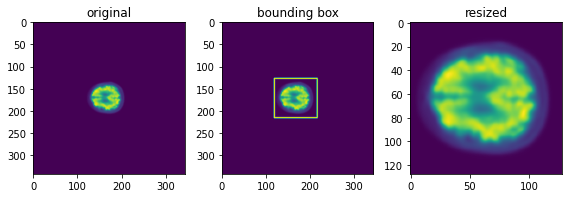

In [ ]:
fig,ax = plt.subplots(1,3, figsize=(8,8))
ax[0].imshow(pos[:,:,int(pos.shape[2]/2)])
ax[0].set_title('original')
index = int(pos.shape[2] / 2) - int(50 / 2)
sliced = pos[:,:,index : index + 50]
rect = find_brain_bounding_box(sliced)
ax[1].imshow(cv2.rectangle(normalize(sliced[:,:,int(sliced.shape[2]/2)]), (rect[0],rect[1]), (rect[2],rect[3]), 1, 2).get())
ax[1].set_title('bounding box')
ax[2].imshow(r_pos[:,:,25])
ax[2].set_title('resized')
plt.tight_layout()
plt.show()

When this all works, we can start loading all the available images, creating the dataset to be used to train the model.

In [ ]:
pos = np.array(list(filter(lambda x: x is not None and np.array(x).shape[-1] == 50, p_uimap(process_scan, pos_images + mod_images))))
pos_label = np.ones(len(pos), dtype=np.uint8)
neg = np.array(list(filter(lambda x: x is not None and np.array(x).shape[-1] == 50, p_uimap(process_scan, neg_images))))
neg_label = np.zeros(len(neg), dtype=np.uint8)

x = np.concatenate((pos, neg), axis=0)
y = np.concatenate((pos_label, neg_label), axis=0)

Error in reading /datasets/drive/MyDrive/Computer Vision/data/positive/OAS30355_AV45_d0861n_moco.4dfp.hdr (file could be damaged)
Error in reading /datasets/drive/MyDrive/Computer Vision/data/positive/OAS30901_AV45_d0155n_moco.4dfp.hdr (file could be damaged)
Error in reading /datasets/drive/MyDrive/Computer Vision/data/positive/OAS30510_PIB_d1259n_moco.4dfp.hdr (file could be damaged)


Error in reading /datasets/drive/MyDrive/Computer Vision/data/negative/OAS30151_AV45_d0064n_moco.4dfp.hdr (file could be damaged)
Error in reading /datasets/drive/MyDrive/Computer Vision/data/negative/OAS30333_AV45_d2891n_moco.4dfp.hdr (file could be damaged)
Error in reading /datasets/drive/MyDrive/Computer Vision/data/negative/OAS30402_AV45_d1085n_moco.4dfp.hdr (file could be damaged)


We can now split it into a train set and validation set, with a validation set ratio of 20%.

In [ ]:
from sklearn.model_selection import train_test_split
VAL_SIZE = 0.2
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=VAL_SIZE, stratify=y)

## Building the Model

To build the model, we'll use Tensorflow 2.x. To train it, we'll use a GPU, if available.

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


We can then build the 3D CNN model of [Zunair et al.](https://arxiv.org/abs/2007.13224) layer by layer, using the implementation provided by the authors themself (available on [keras.io](https://keras.io/examples/vision/3D_image_classification/#make-predictions-on-a-single-ct-scan)).

In [ ]:
def get_model(width=128, height=128, depth=50):
    """Build a 3D convolutional neural network model.
    References
    ----------
    - https://arxiv.org/abs/2007.13224
    """

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


The following function is an helper function that collects all the required instruction to actually train and evaluate the model.

In [ ]:
# Compile model.
def train_model(x_train, y_train, x_test, y_test, epochs=10000, verbose=2):
    # Build model.
    model = get_model(width=128, height=128, depth=50)

    train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    validation_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

    batch_size = 2
    train_dataset = (
        train_loader.shuffle(len(x_train), seed=int(os.getenv('RANDOM_SEED')))
        .batch(batch_size)
        .prefetch(1)
    )
    validation_dataset = (
        validation_loader.shuffle(len(x_test), seed=int(os.getenv('RANDOM_SEED')))
        .batch(batch_size)
        .prefetch(1)
    )

    initial_learning_rate = 0.0001
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
    )
    model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        metrics=['acc'],
    )

    # Define callbacks.
    checkpoint_cb = keras.callbacks.ModelCheckpoint(
        "3d_image_classification.h5", save_best_only=True
    )
    early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=35)

    # Train the model, doing validation at the end of each epoch
    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        shuffle=True,
        verbose=verbose,
        callbacks=[checkpoint_cb, early_stopping_cb],
    )

    model.load_weights("3d_image_classification.h5")
    metrics = model.evaluate(x_test, y_test)
    return history, metrics

While the following is a function to plot the history of the model.

In [ ]:
def plot_results(history):
    fig, ax = plt.subplots(1, 2, figsize=(20, 3))
    ax = ax.ravel()

    for i, metric in enumerate(["acc", "loss"]):
        ax[i].plot(history.history[metric])
        ax[i].plot(history.history["val_" + metric])
        ax[i].set_title("Model {}".format(metric))
        ax[i].set_xlabel("epochs")
        ax[i].set_ylabel(metric)
        ax[i].legend(["train", "val"])
      
    return fig

## Cross Validation

We can now start a stratified 10-fold cross-validation to test our model.

In [ ]:
from sklearn.model_selection import StratifiedKFold

kFold = StratifiedKFold(n_splits=10)
k = 0
models = []
for train, test in kFold.split(x_train, y_train):
    tf.keras.backend.clear_session()
    k += 1
    print("k =", k)
    history, metrics = train_model(x_train[train], y_train[train], x_train[test], y_train[test])
    models.append((history, metrics))

k = 1
Epoch 1/10000
144/144 - 24s - loss: 0.7129 - acc: 0.5590 - val_loss: 0.8047 - val_acc: 0.5000
Epoch 2/10000
144/144 - 6s - loss: 0.6943 - acc: 0.5521 - val_loss: 0.6905 - val_acc: 0.5000
Epoch 3/10000
144/144 - 6s - loss: 0.6750 - acc: 0.6181 - val_loss: 0.9768 - val_acc: 0.5000
Epoch 4/10000
144/144 - 6s - loss: 0.6910 - acc: 0.5764 - val_loss: 0.8799 - val_acc: 0.5312
Epoch 5/10000
144/144 - 6s - loss: 0.6619 - acc: 0.5799 - val_loss: 0.7574 - val_acc: 0.4688
Epoch 6/10000
144/144 - 6s - loss: 0.6403 - acc: 0.6354 - val_loss: 1.2125 - val_acc: 0.5000
Epoch 7/10000
144/144 - 6s - loss: 0.5943 - acc: 0.6597 - val_loss: 0.6674 - val_acc: 0.5625
Epoch 8/10000
144/144 - 6s - loss: 0.6373 - acc: 0.6181 - val_loss: 0.7156 - val_acc: 0.5938
Epoch 9/10000
144/144 - 6s - loss: 0.6281 - acc: 0.6736 - val_loss: 0.7229 - val_acc: 0.5938
Epoch 10/10000
144/144 - 6s - loss: 0.6244 - acc: 0.6424 - val_loss: 0.5998 - val_acc: 0.6250
Epoch 11/10000
144/144 - 6s - loss: 0.6100 - acc: 0.6701 - val

The following are the histories for each fold.

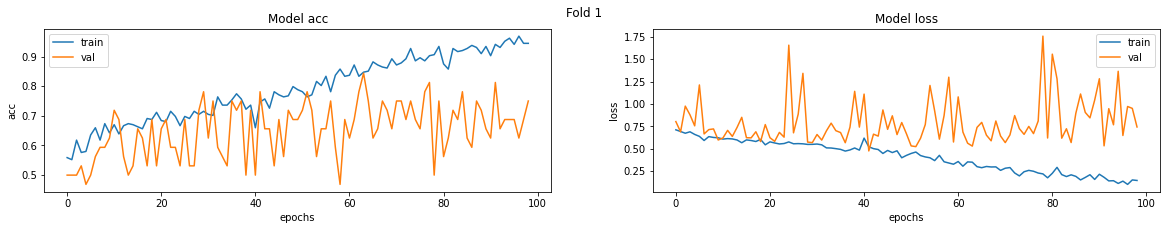

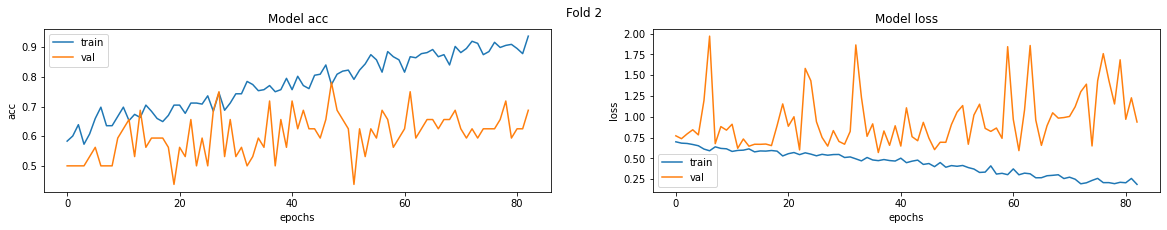

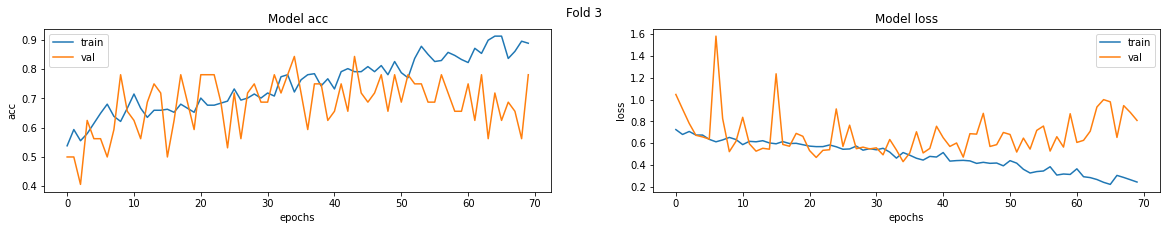

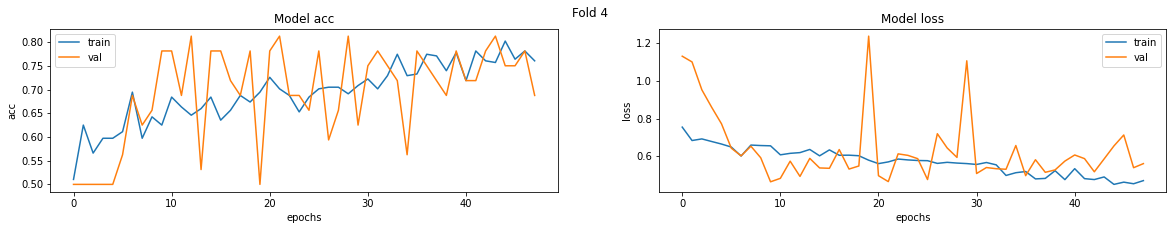

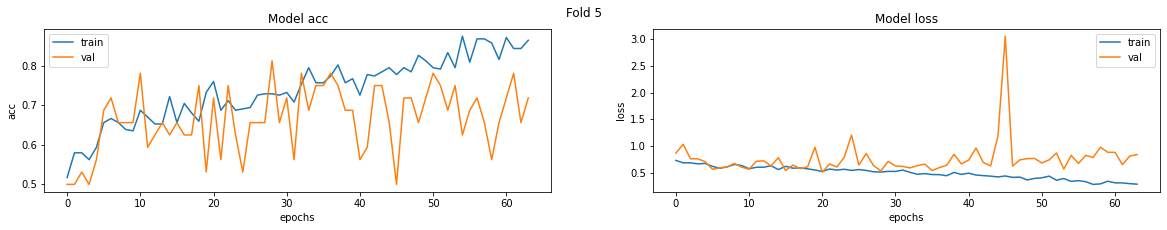

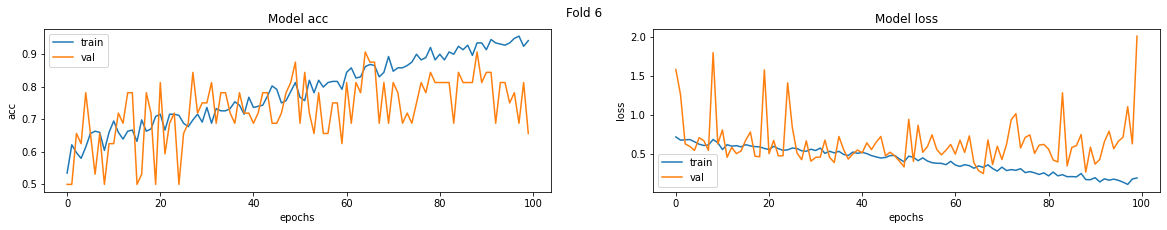

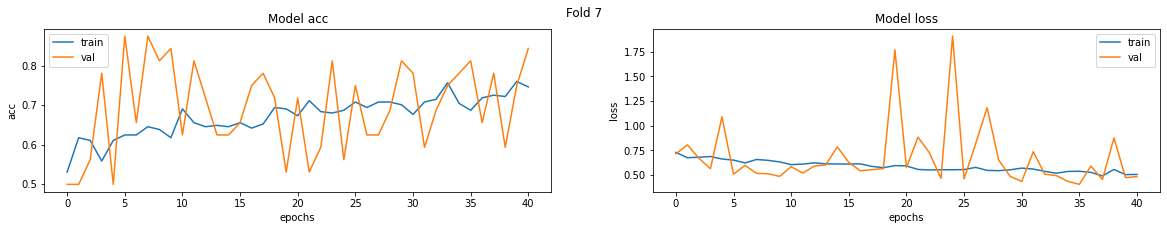

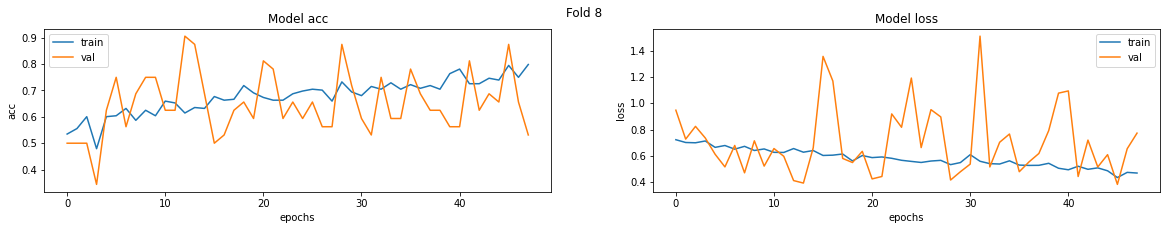

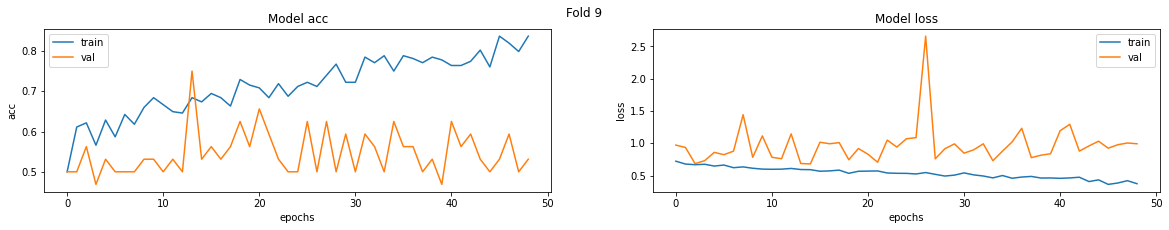

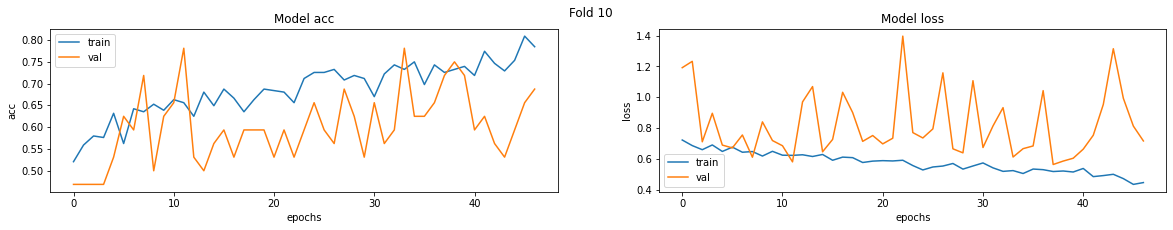

In [ ]:
k = 0
for history, _ in models:
    k += 1
    fig = plot_results(history)
    fig.suptitle(f"Fold {k}")

And the following are plots representing the losses and accuracies of all the folds.

In [ ]:
metrics_in_time = np.array([a for m, a in models])
metrics_in_time

array([[0.47801253, 0.78125   ],
       [0.57155067, 0.71875   ],
       [0.43180808, 0.84375   ],
       [0.46514213, 0.78125   ],
       [0.51431769, 0.71875   ],
       [0.24910727, 0.875     ],
       [0.40657091, 0.8125    ],
       [0.38471329, 0.875     ],
       [0.67971802, 0.53125   ],
       [0.56320202, 0.71875   ]])

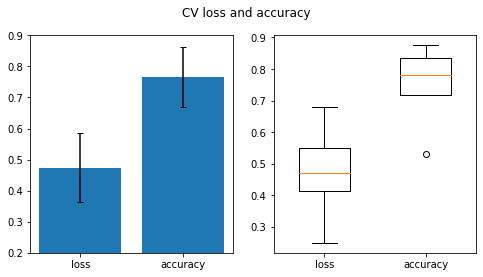

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(8, 4))
ax[0].bar(['loss', 'accuracy'], np.mean(metrics_in_time, axis=0), yerr=np.std(metrics_in_time, axis=0), error_kw={'capsize': 3})
ax[0].set_ylim(0.2,0.9 )
ax[1].boxplot(metrics_in_time, labels=['loss', 'accuracy'], widths=[0.5,0.5])
fig.suptitle("CV loss and accuracy")
plt.show()

## Model Validation

We can then validate the model.

In [ ]:
model, metrics = train_model(x_train, y_train, x_val, y_val)

Epoch 1/10000
160/160 - 9s - loss: 0.6872 - acc: 0.5594 - val_loss: 0.6970 - val_acc: 0.5062
Epoch 2/10000
160/160 - 7s - loss: 0.6561 - acc: 0.6250 - val_loss: 0.7195 - val_acc: 0.5062
Epoch 3/10000
160/160 - 7s - loss: 0.6629 - acc: 0.6250 - val_loss: 0.7046 - val_acc: 0.4938
Epoch 4/10000
160/160 - 7s - loss: 0.6839 - acc: 0.5562 - val_loss: 0.7364 - val_acc: 0.5556
Epoch 5/10000
160/160 - 7s - loss: 0.6413 - acc: 0.6219 - val_loss: 0.5628 - val_acc: 0.6914
Epoch 6/10000
160/160 - 7s - loss: 0.6527 - acc: 0.6406 - val_loss: 0.5152 - val_acc: 0.7778
Epoch 7/10000
160/160 - 7s - loss: 0.6415 - acc: 0.6125 - val_loss: 0.7634 - val_acc: 0.6173
Epoch 8/10000
160/160 - 7s - loss: 0.6285 - acc: 0.6719 - val_loss: 1.8004 - val_acc: 0.4938
Epoch 9/10000
160/160 - 7s - loss: 0.6301 - acc: 0.6406 - val_loss: 0.5770 - val_acc: 0.6543
Epoch 10/10000
160/160 - 7s - loss: 0.6383 - acc: 0.6375 - val_loss: 0.6266 - val_acc: 0.6049
Epoch 11/10000
160/160 - 7s - loss: 0.6217 - acc: 0.6594 - val_loss: 

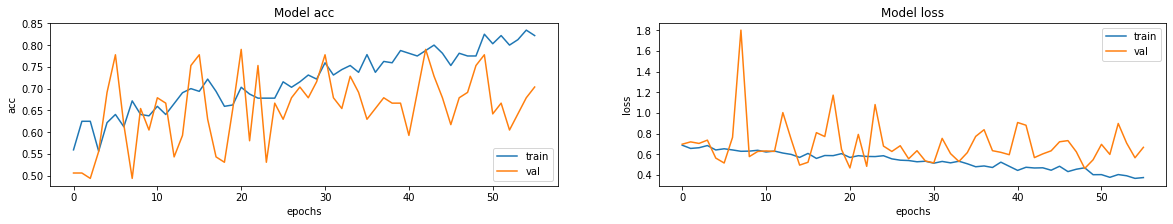

In [ ]:
fig = plot_results(model)
plt.show()

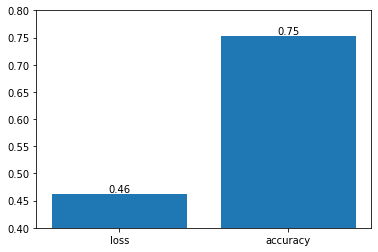

In [ ]:
plt.bar(['loss','accuracy'], metrics)
plt.text('loss', metrics[0], f"{metrics[0]:.2f}", ha='center', va='bottom')
plt.text('accuracy', metrics[1], f"{metrics[1]:.2f}", ha='center', va='bottom')
plt.ylim(0.4, 0.8)
plt.show()

## Final Training

Finally, we can train the model on the entire dataset.

In [ ]:
# Build model.
model = get_model(width=128, height=128, depth=50)

train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))

batch_size = 2
train_dataset = (
    train_loader.shuffle(len(x_train), seed=int(os.getenv('RANDOM_SEED')))
    .batch(batch_size)
    .prefetch(1)
)

initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=['acc'],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5"
)

# Train the model, doing validation at the end of each epoch
history = model.fit(
    train_dataset,
    epochs=45 ,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb],
)

Epoch 1/45
160/160 - 8s - loss: 0.6948 - acc: 0.5781
Epoch 2/45
160/160 - 6s - loss: 0.6663 - acc: 0.6219
Epoch 3/45
160/160 - 7s - loss: 0.6446 - acc: 0.6375
Epoch 4/45
160/160 - 7s - loss: 0.6818 - acc: 0.5688
Epoch 5/45
160/160 - 7s - loss: 0.6404 - acc: 0.6125
Epoch 6/45
160/160 - 6s - loss: 0.6393 - acc: 0.6406
Epoch 7/45
160/160 - 7s - loss: 0.6434 - acc: 0.6250
Epoch 8/45
160/160 - 7s - loss: 0.6080 - acc: 0.6531
Epoch 9/45
160/160 - 6s - loss: 0.6189 - acc: 0.6250
Epoch 10/45
160/160 - 7s - loss: 0.6372 - acc: 0.6094
Epoch 11/45
160/160 - 7s - loss: 0.6185 - acc: 0.6625
Epoch 12/45
160/160 - 7s - loss: 0.6170 - acc: 0.6344
Epoch 13/45
160/160 - 7s - loss: 0.5991 - acc: 0.6594
Epoch 14/45
160/160 - 7s - loss: 0.5810 - acc: 0.7000
Epoch 15/45
160/160 - 7s - loss: 0.5858 - acc: 0.6969
Epoch 16/45
160/160 - 7s - loss: 0.5885 - acc: 0.6750
Epoch 17/45
160/160 - 7s - loss: 0.5424 - acc: 0.7312
Epoch 18/45
160/160 - 7s - loss: 0.5847 - acc: 0.6812
Epoch 19/45
160/160 - 7s - loss: 0.56